# LSTM构建subword-level model进行文本分类

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


## 数据读取：tfds 读取TensorFlow Dataset

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load(
    'imdb_reviews/subwords8k:0.1.0', with_info = True, as_supervised = True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

### 数据集探索

In [5]:
tokenizer = info.features['text'].encoder
print('vocabulary size: {}'.format(tokenizer.vocab_size))

vocabulary size: 8185


In [6]:
# 编码解码
sample_string = 'Tensorflow is cool.'
tokenized_string = tokenizer.encode(sample_string)
print('tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('original string is {}'.format(original_string))

tokenized string is [6307, 2327, 2934, 7961, 9, 2724, 7975]
original string is Tensorflow is cool.


In [7]:
# subword
for token in tokenized_string:
    print('{} --> "{}"'.format(token, tokenizer.decode([token])))

6307 --> "Ten"
2327 --> "sor"
2934 --> "flow"
7961 --> " "
9 --> "is "
2724 --> "cool"
7975 --> "."


In [8]:
# 对dataset变换
buffer_size = 10000
batch_size = 64

train_dataset = train_dataset.shuffle(buffer_size)
# 对每一个batch，找到最长的sequence，做padding
train_dataset = train_dataset.padded_batch(batch_size, train_dataset.output_shapes)
test_dataset = test_dataset.padded_batch(batch_size, test_dataset.output_shapes)

# shape: 数据 (batch_size, seq_length)，label(length)
print(train_dataset.output_shapes)
print(test_dataset.output_shapes)

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


(TensorShape([None, None]), TensorShape([None]))
(TensorShape([None, None]), TensorShape([None]))


## 模型构建：单层双向LSTM

In [9]:
embedding_dim = 16 # 每个词Embedding成长度为16的向量
batch_size = 128
vocab_size = tokenizer.vocab_size

bi_lstm_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(keras.layers.LSTM(units=32, return_sequences=False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])
bi_lstm_model.summary()
bi_lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 145,617
Trainable params: 145,617
Non-trainable params: 0
_________________________________________________________________


In [10]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

# 训练
history_bi_lstm = bi_lstm_model.fit(
    train_dataset, epochs = 10, validation_data = test_dataset, callbacks = callbacks)

Epoch 1/10
391/391 [==============================] - 96s 246ms/step - loss: 0.5303 - accuracy: 0.7281 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 89s 227ms/step - loss: 0.3155 - accuracy: 0.8744 - val_loss: 0.3710 - val_accuracy: 0.8516
Epoch 3/10
391/391 [==============================] - 92s 234ms/step - loss: 0.2585 - accuracy: 0.9050 - val_loss: 0.4360 - val_accuracy: 0.8340
Epoch 4/10
391/391 [==============================] - 90s 229ms/step - loss: 0.2428 - accuracy: 0.9122 - val_loss: 0.4095 - val_accuracy: 0.8407
Epoch 5/10
391/391 [==============================] - 90s 230ms/step - loss: 0.1918 - accuracy: 0.9315 - val_loss: 0.4914 - val_accuracy: 0.8296
Epoch 6/10
391/391 [==============================] - 92s 235ms/step - loss: 0.1688 - accuracy: 0.9418 - val_loss: 0.4415 - val_accuracy: 0.8377
Epoch 7/10
391/391 [==============================] - 90s 231ms/step - loss: 0.1432 - accuracy: 0.9520 - val_loss: 0.5021 

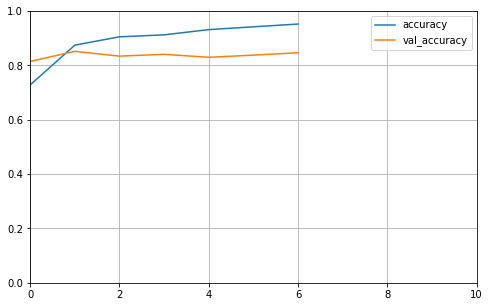

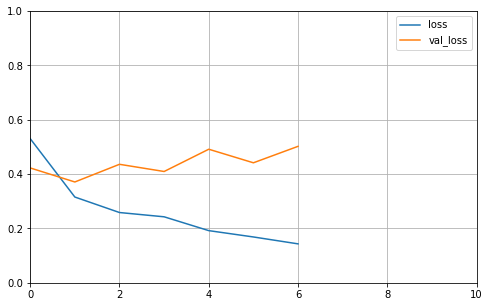

In [11]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()

plot_learning_curves(history_bi_lstm, 'accuracy', 10, 0, 1)
plot_learning_curves(history_bi_lstm, 'loss', 10, 0, 1)

In [12]:
bi_lstm_model.evaluate(test_dataset)

391/391 [==============================] - 28s 72ms/step - loss: 0.5021 - accuracy: 0.8463


[0.5020637243147701, 0.84632]